# Check Bounding Boxex NIH

In [23]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
# from multiprocessing import Pool
import multiprocessing
import time
import random
import pickle
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [18]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'?': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                '??': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [19]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [20]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [40]:
# df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
# start_time = time.time()  

# # Repeats the compute intensive operation on all available cores
# pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
# pool.map_async(txt_to_df, txt_list, callback = collect_results)
# pool.close()
# pool.join()

# # Converts list of lists to a data frame
# print(df.shape)
# print("--- %s seconds ---" % (time.time() - start_time))

(196934, 9)
--- 141.8992350101471 seconds ---


In [41]:
# df.reset_index(drop=True, inplace = True)
# pickle_labels = open('labels.pkl', 'wb') 
# pickle.dump(df, pickle_labels)

In [45]:
df = pd.read_pickle('labels.pkl')

In [46]:
df

?         cell     comment annotation_type  ??  \
0         1-1  Parasitized  No_Comment           Point   1   
1         1-2   Uninfected  No_Comment           Point   1   
2         1-3   Uninfected  No_Comment           Point   1   
3         1-4   Uninfected  No_Comment           Point   1   
4         1-5   Uninfected  No_Comment           Point   1   
...       ...          ...         ...             ...  ..   
196929  4-167  Parasitized  No_comment         Polygon  25   
196930  4-168  Parasitized  No_comment         Polygon  21   
196931  4-169  Parasitized  No_comment         Polygon  20   
196932  4-170  Parasitized  No_comment         Polygon  20   
196933  4-171  Parasitized  No_comment         Polygon  17   

                                                 position  \
0                                          [(2470, 1302)]   
1                                           [(1598, 944)]   
2                                           [(1756, 987)]   
3                                           [(2000, 895)]   
4                                          [(1938, 1006)]   
...                                                   ...   
196929  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
...                                                   ...  
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [47]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [48]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [49]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [50]:
filename =  'IMG_20150623_134547' #'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file

?         cell     comment annotation_type ??        position  \
153322    2-1  Parasitized  No_Comment           Point  1  [(1131, 1205)]   
153323    2-2   Uninfected  No_Comment           Point  1  [(3804, 1277)]   
153324    2-3   Uninfected  No_Comment           Point  1  [(1898, 1277)]   
153325    2-4   Uninfected  No_Comment           Point  1  [(1818, 1350)]   
153326    2-5   Uninfected  No_Comment           Point  1  [(1828, 1481)]   
...       ...          ...         ...             ... ..             ...   
153565  2-244   Uninfected  No_Comment           Point  1  [(2060, 1156)]   
153566  2-245   Uninfected  No_Comment           Point  1  [(2046, 1363)]   
153567  2-246   Uninfected  No_Comment           Point  1   [(1863, 451)]   
153568  2-247   Uninfected  No_Comment           Point  1   [(1865, 602)]   
153569  2-248   Uninfected  No_Comment           Point  1   [(1842, 804)]   

                   filename  \
153322  IMG_20150623_134547   
153323  IMG_20150623_134547   
153324  IMG_20150623_134547   
153325  IMG_20150623_134547   
153326  IMG_20150623_134547   
...                     ...   
153565  IMG_20150623_134547   
153566  IMG_20150623_134547   
153567  IMG_20150623_134547   
153568  IMG_20150623_134547   
153569  IMG_20150623_134547   

                                                 txt_path  \
153322  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153323  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153324  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153325  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153326  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
...                                                   ...   
153565  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153566  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153567  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153568  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153569  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   

                                                 img_path  
153322  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153323  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153324  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153325  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153326  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
...                                                   ...  
153565  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153566  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153567  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153568  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153569  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  

[248 rows x 9 columns]

In [51]:
df_file[df_file['position'].str.len() > 0]

?         cell     comment annotation_type ??        position  \
153322    2-1  Parasitized  No_Comment           Point  1  [(1131, 1205)]   
153323    2-2   Uninfected  No_Comment           Point  1  [(3804, 1277)]   
153324    2-3   Uninfected  No_Comment           Point  1  [(1898, 1277)]   
153325    2-4   Uninfected  No_Comment           Point  1  [(1818, 1350)]   
153326    2-5   Uninfected  No_Comment           Point  1  [(1828, 1481)]   
...       ...          ...         ...             ... ..             ...   
153565  2-244   Uninfected  No_Comment           Point  1  [(2060, 1156)]   
153566  2-245   Uninfected  No_Comment           Point  1  [(2046, 1363)]   
153567  2-246   Uninfected  No_Comment           Point  1   [(1863, 451)]   
153568  2-247   Uninfected  No_Comment           Point  1   [(1865, 602)]   
153569  2-248   Uninfected  No_Comment           Point  1   [(1842, 804)]   

                   filename  \
153322  IMG_20150623_134547   
153323  IMG_20150623_134547   
153324  IMG_20150623_134547   
153325  IMG_20150623_134547   
153326  IMG_20150623_134547   
...                     ...   
153565  IMG_20150623_134547   
153566  IMG_20150623_134547   
153567  IMG_20150623_134547   
153568  IMG_20150623_134547   
153569  IMG_20150623_134547   

                                                 txt_path  \
153322  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153323  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153324  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153325  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153326  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
...                                                   ...   
153565  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153566  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153567  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153568  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   
153569  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...   

                                                 img_path  
153322  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153323  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153324  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153325  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153326  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
...                                                   ...  
153565  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153566  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153567  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153568  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  
153569  ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P...  

[248 rows x 9 columns]

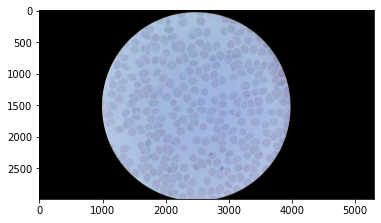

In [52]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

In [53]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

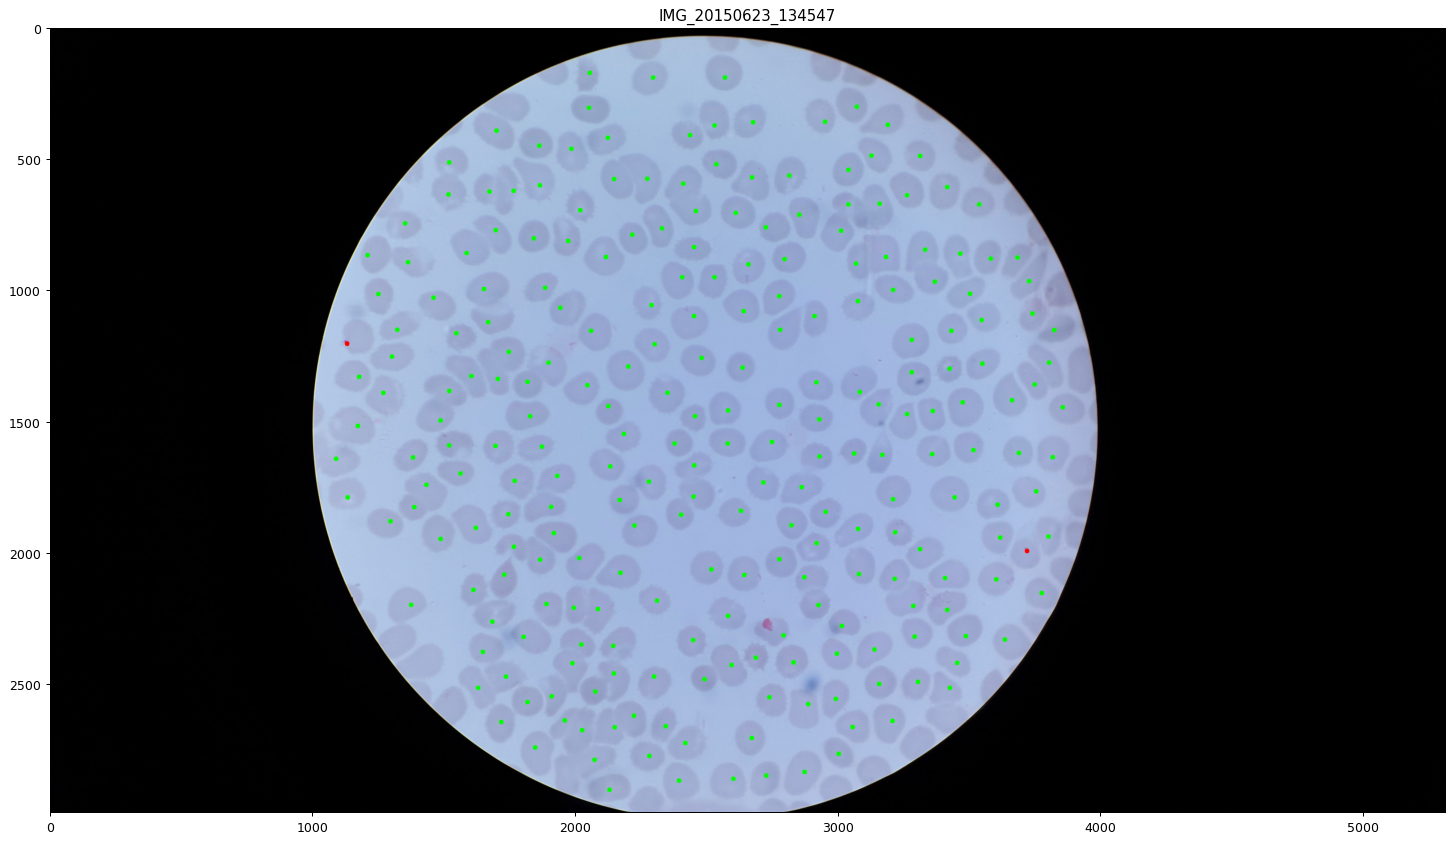

In [54]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

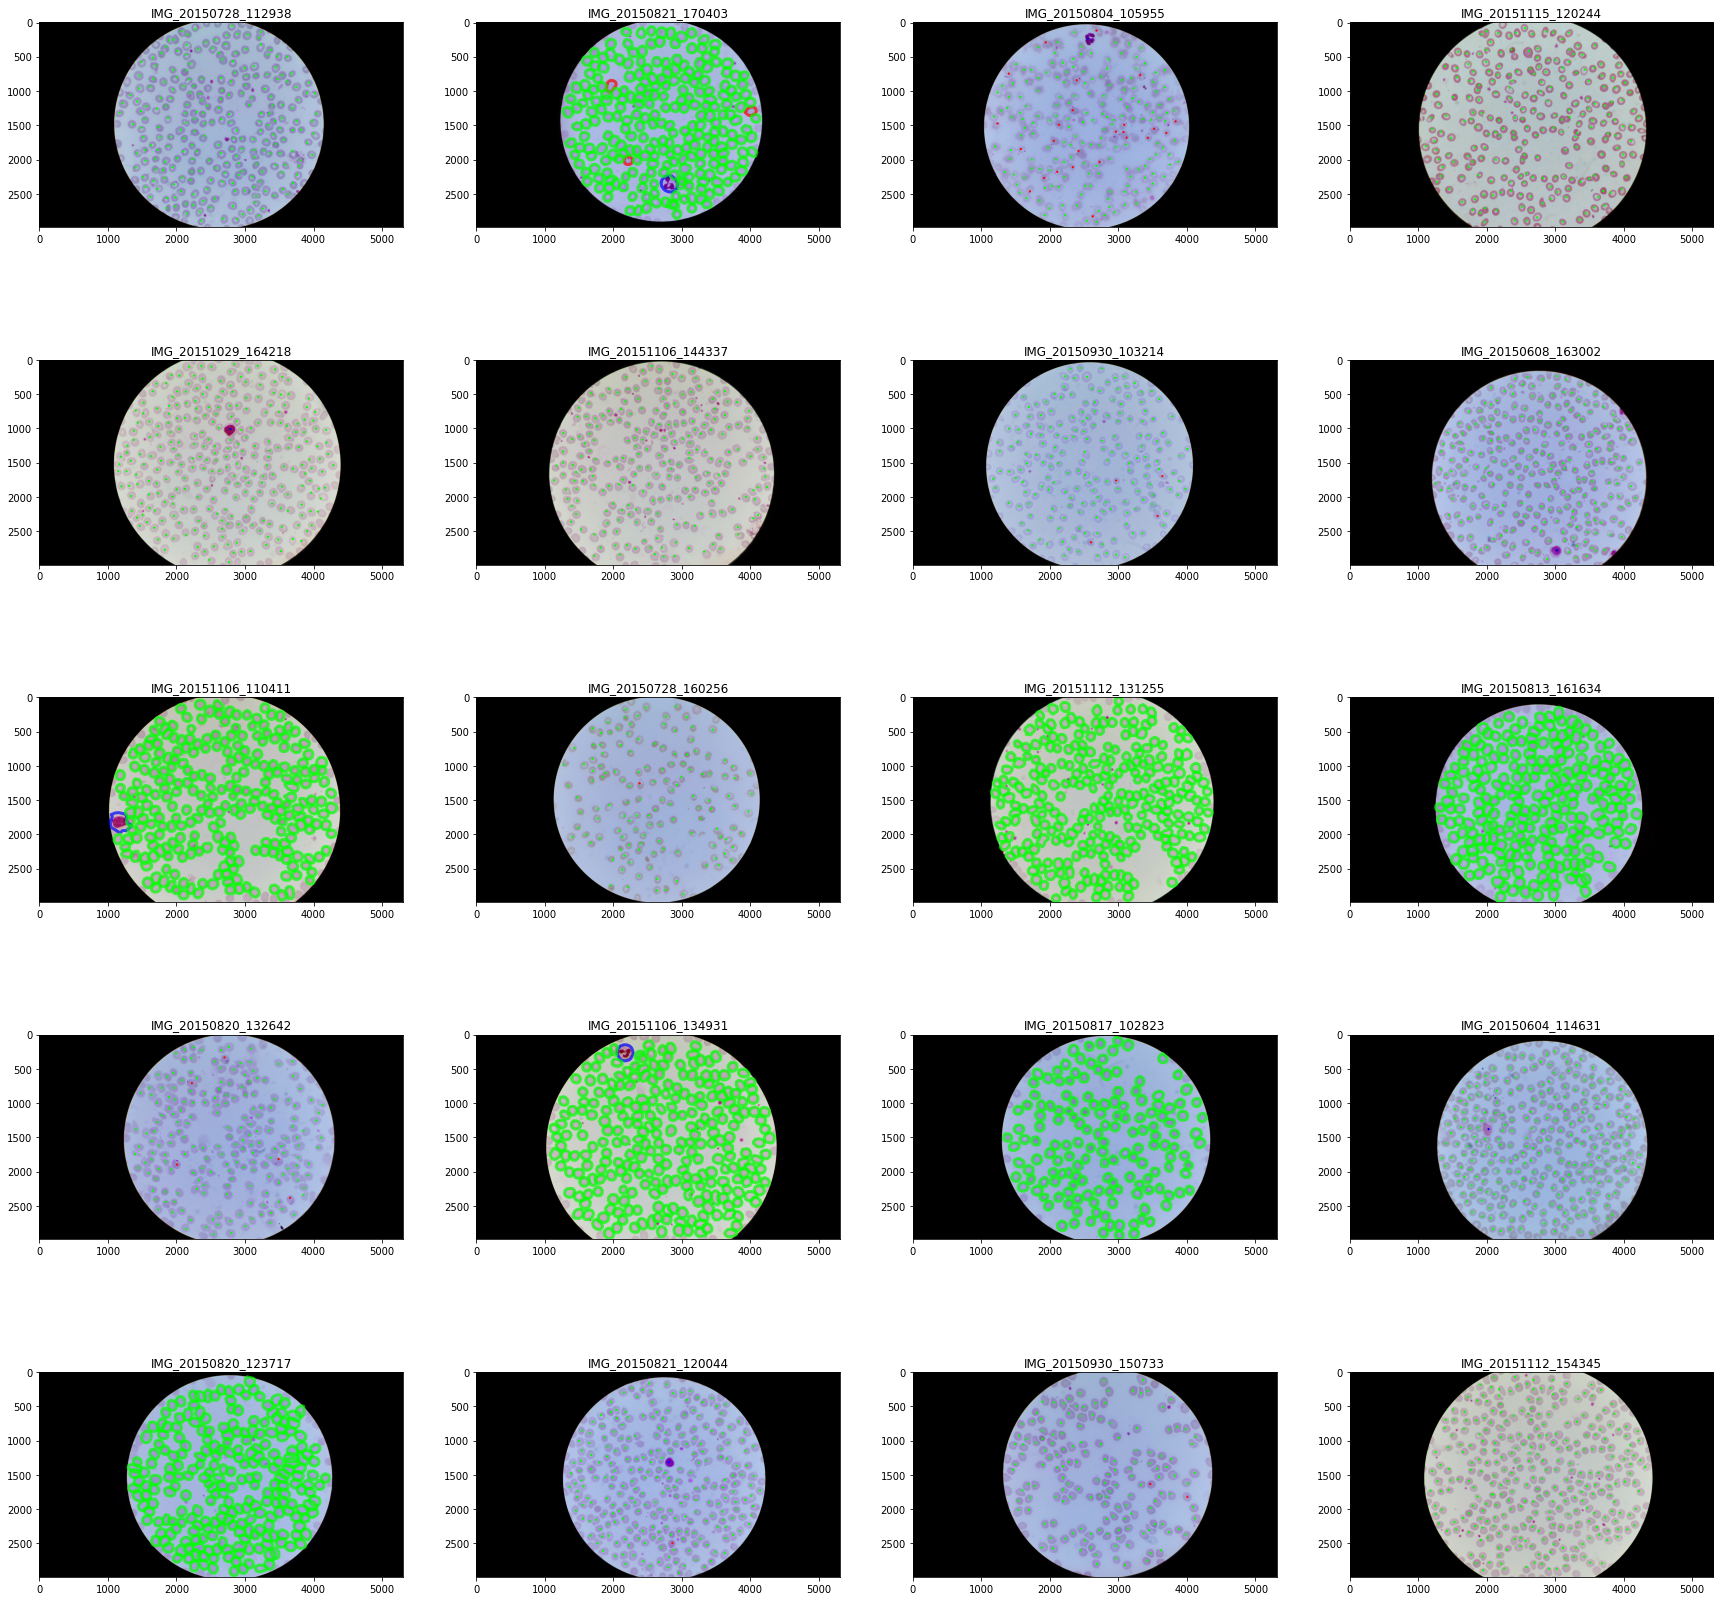

In [56]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [62]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [84]:
filename =  'IMG_20151029_162934'

In [85]:
# for filename in df['filename'].unique():
#     df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'positions'].apply(lambda x: )

In [86]:
# patches = []
# patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

# img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'img_path'][0], cv2.IMREAD_COLOR)
# #img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# # img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# #img = cv2.flip(img, 1)

# empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
# #[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
# mask = np.array(empty_img)

# fig = plt.figure(1, figsize=(20,20), dpi=90)
# ax = fig.add_subplot(111)

# colors = 100*np.random.rand(len(patches))
# p = PatchCollection(patches, alpha=0.8)
# p.set_array(np.array(colors))
# ax.add_collection(p)
# fig.colorbar(p, ax=ax)
# plt.imshow(img)


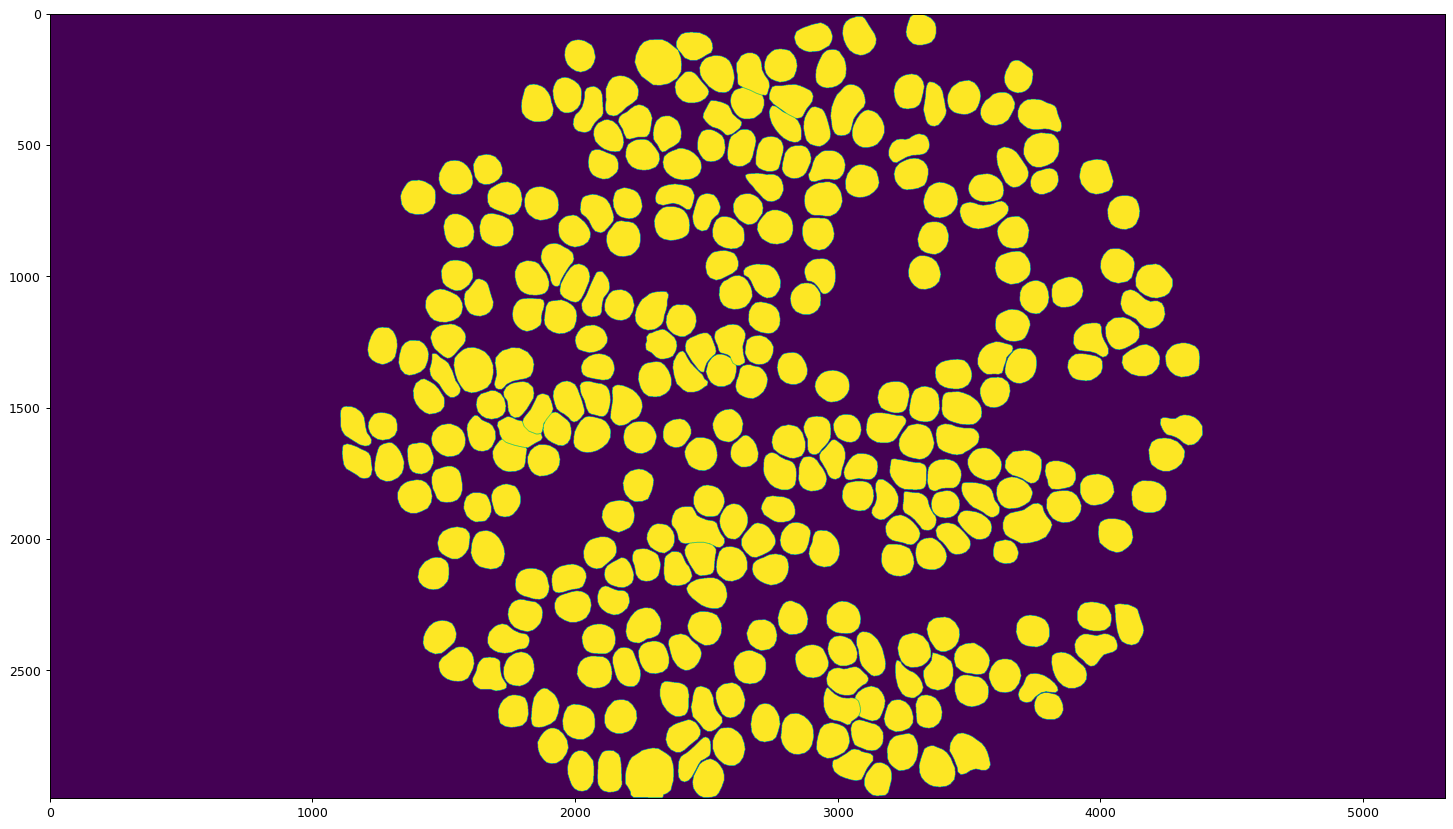

In [87]:

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'][0], cv2.IMREAD_COLOR)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.flip(img, 1)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

plt.imshow(mask)


## Connected Components

In [96]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

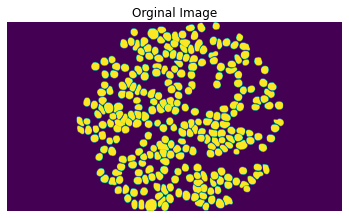

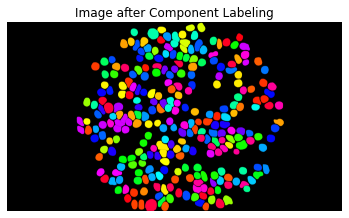

In [97]:
connected_component_label(mask)

In [98]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
270


## Tiling images

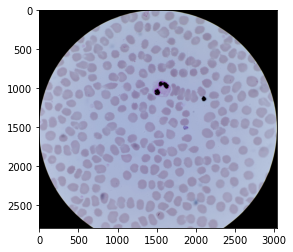

In [141]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
# select circle only
img_gray = rgb2gray(img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [142]:
def plot_tiles(img):
    img_shape = img.shape
    tile_size = (256, 256)
    offset = (256, 256)

    for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            cv2.rectangle(img, (offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(img)


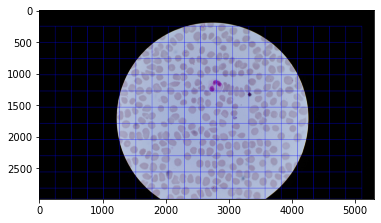

In [143]:
plot_tiles(img)

## Polygon to rectangle

In [58]:
df_file['position'].iloc[-1]

[(2648, 1092)]